# 2024 OIBC Challenge
**(Deep Learning version final)**

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce
import os
from datetime import datetime, timedelta

import torch
from torch.utils.data import DataLoader
from DL_final import NeuralNetwork, ElecDataset, train

## 데이터 전처리

In [5]:
print(os.getcwd())  # 현재 작업 경로 출력

/content


actual_weather_1

In [6]:
# 데이터 불러오기
actual_weather_1 = pd.read_csv("/content/actual_weather_1.csv")

# 'ts'를 datetime 형식으로 변환 후 1시간 단위로 맞추기
actual_weather_1['datetime'] = pd.to_datetime(actual_weather_1['ts'], unit='s')
actual_weather_1['datetime'] = actual_weather_1['datetime'].dt.round('h') + timedelta(hours=9)

# 원래 'ts' 열과 'location' 제거
actual_weather_1.drop(columns=['ts'], inplace=True)
actual_weather_1.drop(columns=['location'], inplace=True)

# 1시간 단위로 그룹화하여 평균을 계산 (location을 제외한 모든 열)
actual_weather_1 = actual_weather_1.groupby(['datetime'], as_index=False).mean()


# weather_forecast에 없는 columns 제거
actual_weather_1.drop(columns=['real_feel_temp_shade'], inplace=True)
actual_weather_1.drop(columns=['pressure'], inplace=True)
actual_weather_1.drop(columns=['appr_temp'], inplace=True)
actual_weather_1.drop(columns=['wind_chill_temp'], inplace=True)

# 결과 확인
actual_weather_1.head()

,datetime,temp,real_feel_temp,rel_hum,dew_point,wind_dir,wind_spd,wind_gust_spd,uv_idx,vis,cld_cvr,ceiling,wet_bulb_temp,precip_1h
0,2024-03-01 00:00:00,8.500000,8.000000,81.000000,5.500000,270.000000,6.100000,17.600000,0.0,20.900000,91.000000,579.000000,7.100000,0.100000
1,2024-03-01 01:00:00,7.158333,3.041667,72.666667,2.508333,234.666667,20.483333,26.366667,0.0,20.783333,97.750000,693.416667,5.091667,0.008333
2,2024-03-01 02:00:00,6.477778,2.111111,75.666667,2.433333,262.888889,21.944444,27.433333,0.0,20.033333,86.333333,616.222222,4.733333,0.011111
3,2024-03-01 03:00:00,6.045455,0.900000,74.545455,1.663636,213.000000,22.490909,27.645455,0.0,19.900000,62.818182,8692.363636,4.209091,0.136364
4,2024-03-01 04:00:00,5.430000,-0.090000,68.100000,-0.030000,256.800000,26.140000,42.440000,0.0,23.800000,38.100000,10911.800000,3.180000,0.410000


weather_forecast_1

In [7]:
# 데이터 불러오기
weather_forecast_1 = pd.read_csv("/content//weather_forecast_1.csv")

# 'ts'를 datetime 형식으로 변환 후 1시간 단위로 맞추기
weather_forecast_1['datetime'] = pd.to_datetime(weather_forecast_1['ts'], unit='s')
weather_forecast_1['datetime'] = weather_forecast_1['datetime'].dt.round('h') + timedelta(hours=9)

# 원래 'ts' 열 제거, 'base_ts' 열 제거, 'location' 제거
weather_forecast_1.drop(columns=['ts'], inplace=True)
weather_forecast_1.drop(columns=['base_ts'], inplace=True)
weather_forecast_1.drop(columns=['location'], inplace=True)

# 1시간 단위로 그룹화하여 평균을 계산 (location을 제외한 모든 열)
weather_forecast_1 = weather_forecast_1.groupby(['datetime'], as_index=False).mean()


# 예보 데이터의 columns 순서를 actual_weather columns 순서와 맞추기
weather_forecast_1 = weather_forecast_1[['datetime', 'temp', 'real_feel_temp', 'rel_hum',
       'dew_point', 'wind_dir', 'wind_spd', 'wind_gust_spd', 'uv_idx', 'vis',
       'cld_cvr', 'ceiling', 'wet_bulb_temp', 'total_liq']]
weather_forecast_1['precip_1h'] = weather_forecast_1['total_liq']
weather_forecast_1.drop(columns=['total_liq'], inplace=True)

# 결과 확인
weather_forecast_1.head()

,datetime,temp,real_feel_temp,rel_hum,dew_point,wind_dir,wind_spd,wind_gust_spd,uv_idx,vis,cld_cvr,ceiling,wet_bulb_temp,precip_1h
0,2024-03-02 00:00:00,1.728394,-4.320987,64.333333,-4.320987,335.555556,22.048022,50.604944,0.0,16.093400,75.555556,1700.106667,-0.555556,0.000000
1,2024-03-02 01:00:00,1.851852,-4.506173,64.333333,-4.135800,335.000000,22.048022,50.640711,0.0,15.378140,84.777778,1249.680000,-0.432099,0.056444
2,2024-03-02 02:00:00,1.790123,-5.061728,66.333333,-3.950616,334.444444,22.656000,51.481144,0.0,14.392882,89.333333,1229.360000,-0.370370,0.197556
3,2024-03-02 03:00:00,1.604940,-5.308640,67.333333,-3.888887,333.777778,23.263967,51.463267,0.0,15.195758,94.555556,1933.786667,-0.370370,0.084667
4,2024-03-02 04:00:00,1.851852,-4.876541,66.444444,-3.950616,333.888889,23.871922,50.837400,0.0,15.825200,82.555556,2600.960000,-0.308642,0.000000


actual_weather_2

In [8]:
# 데이터 불러오기
actual_weather_2 = pd.read_csv("/content/actual_weather_2.csv")

# 'ts'를 datetime 형식으로 변환 후 1시간 단위로 맞추기
actual_weather_2['datetime'] = pd.to_datetime(actual_weather_2['ts'], unit='s')
actual_weather_2['datetime'] = actual_weather_2['datetime'].dt.round('h') + timedelta(hours=9)

# 원래 'ts' 열과 'location' 제거
actual_weather_2.drop(columns=['ts'], inplace=True)
actual_weather_2.drop(columns=['location'], inplace=True)

# 1시간 단위로 그룹화하여 평균을 계산 (location을 제외한 모든 열)
actual_weather_2 = actual_weather_2.groupby(['datetime'], as_index=False).mean()

# 결과 확인
actual_weather_2.head()

,datetime,cloud,temp,temp_max,temp_min,humidity,ground_press,wind_speed,wind_dir,rain,snow
0,2024-03-01 00:00:00,89.333333,6.146667,6.146667,6.146667,74.666667,1022.666667,8.553333,345.333333,0.17,0.0
1,2024-03-01 01:00:00,83.500000,6.255000,6.255000,6.255000,70.500000,1022.500000,6.256667,342.000000,0.00,0.0
2,2024-03-01 02:00:00,84.333333,5.926667,5.926667,5.926667,67.833333,1022.833333,7.291667,343.000000,0.21,0.0
3,2024-03-01 03:00:00,83.666667,5.198333,5.198333,5.198333,63.833333,1023.500000,7.520000,342.333333,0.00,0.0
4,2024-03-01 04:00:00,42.166667,4.433333,4.433333,4.433333,64.833333,1023.833333,7.330000,342.000000,0.00,0.0


weather_forecast_2

In [9]:
# 데이터 불러오기
weather_forecast_2 = pd.read_csv("/content/weather_forecast_2.csv")

# 'ts'를 datetime 형식으로 변환 후 1시간 단위로 맞추기
weather_forecast_2['datetime'] = pd.to_datetime(weather_forecast_2['ts'], unit='s')
weather_forecast_2['datetime'] = weather_forecast_2['datetime'].dt.round('h') + timedelta(hours=9)

# 원래 'ts' 열과 'location' 제거, 'base_ts' 제거
weather_forecast_2.drop(columns=['ts'], inplace=True)
weather_forecast_2.drop(columns=['location'], inplace=True)
weather_forecast_2.drop(columns=['base_ts'], inplace=True)

# 1시간 단위로 그룹화하여 평균을 계산 (location을 제외한 모든 열)
weather_forecast_2 = weather_forecast_2.groupby(['datetime'], as_index=False).mean()

# 결과 확인
weather_forecast_2.head()

,datetime,cloud,temp,temp_max,temp_min,humidity,ground_press,wind_speed,wind_dir,rain,snow
0,2024-03-02 00:00:00,100.000000,1.213333,1.213333,1.213333,60.333333,1027.000000,8.306667,332.333333,0.0,0.0
1,2024-03-02 01:00:00,100.000000,1.280000,1.280000,1.280000,61.000000,1027.000000,8.043333,333.666667,0.0,0.0
2,2024-03-02 02:00:00,100.000000,1.323333,1.323333,1.323333,60.666667,1026.666667,7.626667,333.000000,0.0,0.0
3,2024-03-02 03:00:00,100.000000,1.323333,1.323333,1.323333,60.666667,1026.000000,7.310000,332.666667,0.0,0.0
4,2024-03-02 04:00:00,96.333333,1.356667,1.356667,1.356667,60.666667,1026.000000,7.076667,331.666667,0.0,0.0


elec_supply

In [10]:
# 데이터 불러오기
elec_supply = pd.read_csv("/content/elec_supply.csv")

# 'ts'를 datetime 형식으로 변환 후 1시간 단위로 맞추기
elec_supply['datetime'] = pd.to_datetime(elec_supply['ts'], unit='s')
elec_supply['datetime'] = elec_supply['datetime'].dt.round('h') + timedelta(hours=9)

# 1시간 단위로 그룹화하여 평균을 계산
elec_supply = elec_supply.groupby(['datetime'], as_index=False).mean()

# 결과 확인
elec_supply.drop(columns=['ts'], inplace=True)  # 원래 'ts' 열 제거
elec_supply.head()

,datetime,공급능력(kW),현재 수요(kW),태양광 발전량kW),풍력 발전량(kW),신재생 발전량 총합(kW),공급 예비력(kW),운영 예비력(kW)
0,2024-01-01 00:00:00,1.285000e+06,757500.000000,0.0,115593.233333,123350.666667,527166.666667,328500.000000
1,2024-01-01 01:00:00,1.238308e+06,727538.461538,0.0,68802.153846,77036.569231,510692.307692,312692.307692
2,2024-01-01 02:00:00,1.214818e+06,694090.909091,0.0,45923.181818,53740.109091,520727.272727,318545.454545
3,2024-01-01 03:00:00,1.207923e+06,672000.000000,0.0,38567.161538,46614.815385,536000.000000,291000.000000
4,2024-01-01 04:00:00,1.192364e+06,666000.000000,0.0,22849.272727,30575.990909,526363.636364,318272.727273


smp_da

In [11]:
# 데이터 불러오기
smp_da = pd.read_csv("/content/smp_da.csv")

# 'ts'를 datetime 형식으로 변환 후 1시간 단위로 맞추기
smp_da['datetime'] = pd.to_datetime(smp_da['ts'], unit='s') + timedelta(hours=9)

# 결과 확인
smp_da.drop(columns=['ts'], inplace=True)  # 원래 'ts' 열 제거
smp_da.head()

,하루전가격(원/kWh),datetime
0,107.39,2024-03-01 00:00:00
1,107.39,2024-03-01 01:00:00
2,95.30,2024-03-01 02:00:00
3,87.89,2024-03-01 03:00:00
4,0.00,2024-03-01 04:00:00


smp_rt_rc

In [12]:
# 데이터 불러오기
smp_rt_rc = pd.read_csv("/content/smp_rt_rc.csv")

# 'ts'를 datetime 형식으로 변환 후 1시간 단위로 맞추기
smp_rt_rc['datetime'] = pd.to_datetime(smp_rt_rc['ts'], unit='s')
smp_rt_rc['datetime'] = smp_rt_rc['datetime'].dt.round('h') + timedelta(hours=9)

# 1시간 단위로 그룹화하여 평균을 계산
smp_rt_rc = smp_rt_rc.groupby(['datetime'], as_index=False).mean()

# 결과 확인
smp_rt_rc.drop(columns=['ts'], inplace=True)  # 원래 'ts' 열 제거
smp_rt_rc.head()

,datetime,실시간 임시 가격(원/kWh),실시간 확정 가격(원/kWh)
0,2024-03-01 00:00:00,95.30,95.30
1,2024-03-01 01:00:00,107.39,107.39
2,2024-03-01 02:00:00,95.30,95.30
3,2024-03-01 03:00:00,87.89,87.89
4,2024-03-01 04:00:00,86.50,86.50


##### X 데이터

- 제주 기상 실측_1 (n+1)
- 제주 기상 실측_2 (n+1)
- 하루 전 시장 전기 예측 (n)
- 제주 전력 시장 실시간 (n-1)
- 제주 전력 시장 현황 (n-1)

In [13]:
actual_weather_1
actual_weather_2
weather_forecast_1
weather_forecast_2
smp_da_x = smp_da.copy()
smp_da_x['datetime'] += pd.Timedelta(days=1)
smp_rt_rc['datetime'] += pd.Timedelta(days=2)
elec_supply['datetime'] += pd.Timedelta(days=2)

In [14]:
dfs = [actual_weather_1, actual_weather_2, smp_da_x, smp_rt_rc, elec_supply]

X = reduce(lambda left, right: pd.merge(left, right, on='datetime', how='outer'), dfs)

##### Y 데이터

- 하루 전 시장 전기 예측 가격(n+1)

In [15]:
Y = smp_da

##### 날짜 설정

In [16]:
target_date = {
  # 최소 2024-03-04
  "train_start_date": '2024-03-03',
  # 최대 2024-10-22
  "train_end_date": '2024-10-22',
}

In [17]:
X = X.loc[
  (X['datetime'] > target_date['train_start_date']) &
  (X['datetime'] <= target_date['train_end_date'])
]

In [18]:
Y = Y.loc[
  (Y['datetime'] > target_date['train_start_date']) &
  (Y['datetime'] <= target_date['train_end_date'])
]

In [19]:
targ = datetime.strptime(target_date['train_start_date'], '%Y-%m-%d') + timedelta(hours=1)
endd = datetime.strptime(target_date['train_end_date'], '%Y-%m-%d')

In [20]:
# X 데이터의 특정 시간이 누락되었기 때문에
# Y 데이터에서도 누락된 시간대를 제거한다.

while targ <= endd:
  if not len(X.loc[X['datetime'] == targ]):
    idx = Y[Y['datetime'] == targ].index
    Y.drop(idx, inplace=True)

  targ = targ + timedelta(hours=1)

데이터 확인

In [21]:
X.head()

,datetime,temp_x,real_feel_temp,rel_hum,dew_point,wind_dir_x,wind_spd,wind_gust_spd,uv_idx,vis,...,하루전가격(원/kWh),실시간 임시 가격(원/kWh),실시간 확정 가격(원/kWh),공급능력(kW),현재 수요(kW),태양광 발전량kW),풍력 발전량(kW),신재생 발전량 총합(kW),공급 예비력(kW),운영 예비력(kW)
1441,2024-03-03 01:00:00,4.962500,1.650000,56.125000,-3.112500,246.375000,16.912500,24.993750,0.0,25.937500,...,138.50,107.39,107.39,1.367154e+06,764692.307692,0.0,213928.384615,229070.230769,602692.307692,279846.153846
1442,2024-03-03 02:00:00,4.836364,0.918182,57.727273,-2.918182,245.727273,18.227273,22.754545,0.0,25.027273,...,99.48,95.30,95.30,1.389455e+06,736818.181818,0.0,234674.181818,249718.181818,652636.363636,328090.909091
1443,2024-03-03 03:00:00,4.666667,1.811111,57.777778,-3.011111,250.222222,15.344444,20.266667,0.0,23.255556,...,95.38,87.89,87.89,1.370923e+06,733461.538462,0.0,216275.153846,231237.153846,637384.615385,312538.461538
1444,2024-03-03 04:00:00,4.910000,1.240000,58.400000,-2.670000,256.600000,18.270000,28.230000,0.0,26.060000,...,91.24,86.50,86.50,1.378545e+06,744000.000000,0.0,223340.090909,238393.363636,634818.181818,309636.363636
1445,2024-03-03 05:00:00,5.516667,2.708333,56.833333,-2.525000,257.083333,16.166667,19.816667,0.0,22.541667,...,91.24,88.78,88.78,1.391462e+06,756538.461538,0.0,235738.000000,250772.615385,634923.076923,308615.384615


In [22]:
len(X), len(Y)

(5592, 5592)

## 파이토치 모델 학습

### 모델 구성

In [23]:
if torch.cuda.is_available():
  print(torch.cuda.get_device_name())
  print(torch.__version__)
  print(torch.version.cuda)
  x = torch.randn(1).cuda()
  print(x)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

NVIDIA L4
2.5.0+cu121
12.1
tensor([-1.4302], device='cuda:0')


device(type='cuda', index=0)

##### Dataset & dataloader 구성

In [24]:
dataset = ElecDataset(X, Y)

dataloader = DataLoader(dataset=dataset,
                        batch_size=32,
                        shuffle=True,
                        drop_last=False)

### Custom Loss

In [218]:
def customloss(predict, y):#학습용
    predict = predict.squeeze()

    e1 = torch.zeros_like(y)
    e2 = torch.zeros_like(y)
    accuracy = torch.zeros_like(y, dtype=torch.bool)

    positive_mask = y > 0
    negative_mask = y <= 0

    e1_mask = y > 0  # y > 0인 부분 마스크
    e2_mask = y < -1  # y <= 0인 부분 마스크
    e2_adjusted_mask = (y <= 0) & (y >= -1)
    # 각 마스크 조건에 맞는 부분에 대해서만 e1, e2를 계산합니다.
    # e1과 e2에서 분모에 작은 상수를 추가하여 0으로 나누는 것을 방지
    e1[e1_mask] = torch.abs((y[e1_mask] - predict[e1_mask]) / (y[e1_mask]))
    e2[e2_mask] = torch.abs((y[e2_mask] - predict[e2_mask]) / (-y[e2_mask]))
    e2[e2_adjusted_mask] = torch.abs((y[e2_adjusted_mask] - predict[e2_adjusted_mask]) / (-1))

    accuracy[positive_mask] = (predict[positive_mask] > 0)
    accuracy[negative_mask] = (predict[negative_mask] <= 0)

    e1_mean = e1[e1 != 0].mean() if (e1 != 0).any() else torch.tensor(0.0)
    e2_mean = e2[e2 != 0].mean() if (e2 != 0).any() else torch.tensor(0.0)

    accuracy_mean = accuracy.float().mean()

    e_F = 0.2 * e1_mean + 0.8 * e2_mean - (accuracy_mean - 0.95)
    if e_F<0:
      e_F=0
    e_F_square = e_F**2
    mse_loss = torch.mean((y - predict)**2)

    excess_predict = predict[predict > 100] - 100
    loss_new = torch.sum(excess_predict ** 2) if excess_predict.numel() > 0 else torch.tensor(0.0)

    return e_F_square*10+mse_loss+ loss_new

### 학습

##### 하이퍼 파라미터

In [ ]:
input_size = len(X.columns) - 1  # Number of input features
output_size = 1  # Single output
model = NeuralNetwork(input_size, output_size)

In [221]:
learning_rate = 3e-6
epoches=100

criterion = customloss




optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [222]:
model, train_history = train(model, dataloader, criterion, optimizer, epoches, device)

100%|█████████████████████████████████████████████████████████████| 175/175 [00:09<00:00, 19.24it/s]


Epoch [1/100], Loss: 5836.5938


100%|█████████████████████████████████████████████████████████████| 175/175 [00:09<00:00, 19.35it/s]


Epoch [2/100], Loss: 5515.5238


100%|█████████████████████████████████████████████████████████████| 175/175 [00:09<00:00, 19.27it/s]


Epoch [3/100], Loss: 5740.1145


100%|█████████████████████████████████████████████████████████████| 175/175 [00:09<00:00, 19.26it/s]


Epoch [4/100], Loss: 5554.5704


100%|█████████████████████████████████████████████████████████████| 175/175 [00:09<00:00, 19.21it/s]


Epoch [5/100], Loss: 5677.3627


100%|█████████████████████████████████████████████████████████████| 175/175 [00:09<00:00, 19.01it/s]


Epoch [6/100], Loss: 5526.9294


100%|█████████████████████████████████████████████████████████████| 175/175 [00:09<00:00, 19.29it/s]


Epoch [7/100], Loss: 5764.8064


100%|█████████████████████████████████████████████████████████████| 175/175 [00:09<00:00, 19.29it/s]


Epoch [8/100], Loss: 5595.4842


100%|█████████████████████████████████████████████████████████████| 175/175 [00:09<00:00, 19.23it/s]


Epoch [9/100], Loss: 5659.7850


100%|█████████████████████████████████████████████████████████████| 175/175 [00:09<00:00, 19.15it/s]


Epoch [10/100], Loss: 5630.1068


100%|█████████████████████████████████████████████████████████████| 175/175 [00:09<00:00, 19.13it/s]


Epoch [11/100], Loss: 5643.9137


100%|█████████████████████████████████████████████████████████████| 175/175 [00:09<00:00, 18.97it/s]


Epoch [12/100], Loss: 5745.9704


 19%|███████████▋                                                  | 33/175 [00:01<00:07, 18.48it/s]


KeyboardInterrupt: 

##### 학습 loss

In [38]:
plt.plot(train_history)

plt.title('Model Loss')
plt.xlabel('epoches')
plt.ylabel('loss')
plt.grid(True, linestyle='--')

plt.show()

NameError: name 'train_history' is not defined

### 모델 저장

In [235]:
torch.save(model.state_dict(), 'smp_model_1001.pth')

##모델 예측

In [236]:
model.load_state_dict(torch.load('/content/smp_model_100.pth'))

# 모델을 평가 모드로 전환 (테스트 시에만 필요)
model.eval()

<ipython-input-236-91f6472d2433>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/smp_model_100.pth'))


NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=33, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU()
    (10): Linear(in_features=256, out_features=256, bias=True)
    (11): ReLU()
    (12): Linear(in_features=256, out_features=128, bias=True)
    (13): ReLU()
    (14): Linear(in_features=128, out_features=32, bias=True)
    (15): ReLU()
    (16): Linear(in_features=32, out_features=8, bias=True)
    (17): ReLU()
    (18): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [214]:
# 예측할 날짜
# 10일 오전 11시까지 제출할거면 11일걸 예측해야하므로 '2024-11-11'

predict_target_date = '2024-11-06'

In [192]:
dfs = [weather_forecast_1, weather_forecast_2, smp_da_x, smp_rt_rc, elec_supply]

test_data = reduce(lambda left, right: pd.merge(left, right, on='datetime', how='inner'), dfs)

target_day = datetime.strptime(predict_target_date, '%Y-%m-%d')

target_data = test_data.loc[
  (test_data['datetime'] > target_day) &
  (test_data['datetime'] <= target_day + timedelta(days=1))
]

In [193]:
# 어짜피 예측할거기 때문에 Y는 형식만 맞추기
Y = smp_da

predict_set = ElecDataset(target_data, Y.iloc[:24])

predict_dataloader = DataLoader(dataset=predict_set,
                        batch_size=24,
                        shuffle=False)

<ipython-input-3-dc488d6ac267>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_data[columns_to_scale] = scaler.fit_transform(x_data[columns_to_scale])


In [240]:
# 예측할 날짜
# 10일 오전 11시까지 제출할거면 11일걸 예측해야하므로 '2024-11-11'

predict_target_date = '2024-11-03'

dfs = [weather_forecast_1, weather_forecast_2, smp_da_x, smp_rt_rc, elec_supply]

test_data = reduce(lambda left, right: pd.merge(left, right, on='datetime', how='inner'), dfs)

target_day = datetime.strptime(predict_target_date, '%Y-%m-%d')

target_data = test_data.loc[
  (test_data['datetime'] > target_day) &
  (test_data['datetime'] <= target_day + timedelta(days=1))
]

# 어짜피 예측할거기 때문에 Y는 형식만 맞추기
Y = smp_da

predict_set = ElecDataset(target_data, Y.iloc[:24])

predict_dataloader = DataLoader(dataset=predict_set,
                        batch_size=24,
                        shuffle=False)

model.eval()

with torch.no_grad():
  for inputs, _ in predict_dataloader:
    inputs = inputs.to(device)
    predictions = model(inputs)

flattened_list = predictions.view(-1).tolist()

print(flattened_list)

[0.7617631061016423, 12.086425442689832, 31.137525803209282, 69.6897545899582, 107.50849598495125, 108.3438122859007, 113.73980040866508, 88.89847055319842, 33.36552170081455, 97.75725573283611, 99.25676438541427, 102.97888581951553, 82.65534969633772, 84.90290243129412, 80.34651393127575, 93.21973670745902, 96.33011154749133, 111.37613522545897, 117.19908648331547, 107.20468111514627, 105.20398382693148, 112.40270286528985, 105.94049864917463, 113.737645057772]


<ipython-input-3-dc488d6ac267>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_data[columns_to_scale] = scaler.fit_transform(x_data[columns_to_scale])


In [241]:
#flattened_list = predictions.view(-1).tolist()

print(flattened_list)

[0.7617631061016423, 12.086425442689832, 31.137525803209282, 69.6897545899582, 107.50849598495125, 108.3438122859007, 113.73980040866508, 88.89847055319842, 33.36552170081455, 97.75725573283611, 99.25676438541427, 102.97888581951553, 82.65534969633772, 84.90290243129412, 80.34651393127575, 93.21973670745902, 96.33011154749133, 111.37613522545897, 117.19908648331547, 107.20468111514627, 105.20398382693148, 112.40270286528985, 105.94049864917463, 113.737645057772]


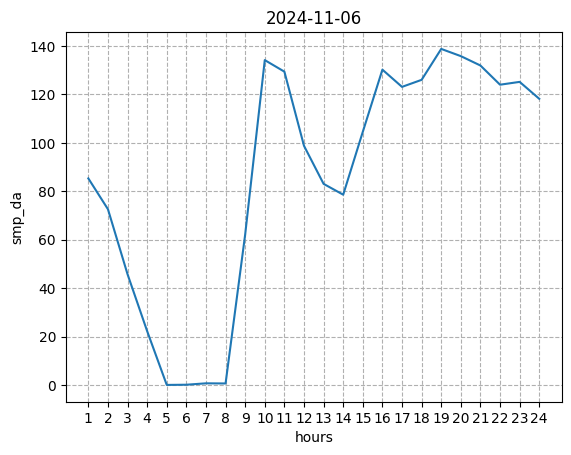

In [239]:
plt.plot(list(range(1, 25)), flattened_list)

plt.title(predict_target_date)
plt.xlabel('hours')
plt.ylabel('smp_da')
plt.xticks(list(range(1,25, 1)))
plt.grid(True, linestyle='--')

plt.show()